---
title       : "Extremum estimation"
subtitle    :
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "ee.bib"
---

<a rel="license"
href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative
Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png"
/></a><br />This work is licensed under a <a rel="license"
href="http://creativecommons.org/licenses/by-sa/4.0/">Creative
Commons Attribution-ShareAlike 4.0 International License</a>.

### About this document {-}

This document was created using Weave.jl. The code is available in
[the course github
repository](https://github.com/ubcecon/ECON628_2018/paul). The same
document generates both static webpages and associated jupyter
notebooks.

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\def\inprob{\,{\buildrel p \over \rightarrow}\,} 
\def\indist{\,{\buildrel d \over \rightarrow}\,} 
$$

# Introduction

As you saw in 627, many, perhaps most, estimators in econometrics are
extrumem estimators. That is, many estimators are defined by
$$
\hat{\theta} = \argmax_{\theta \in \Theta} \hat{Q}_n(\theta)
$$
where $\hat{Q}_n(\theta)$ is some objective function that depends on
data. Examples include maximum likelihood,
$$
\hat{Q}_n(\theta) = \frac{1}{n} \sum_{i=1}^n f(z_i | \theta)
$$
GMM,
$$
\hat{Q}_n(\theta) = \left(\frac{1}{n} \sum_{i=1}^n g(z_i,
\theta)\right)' \hat{W} \left(\frac{1}{n} \sum_{i=1}^n g(z_i,
\theta)\right)
$$
and nonlinear least squares
$$
\hat{Q}_n(\theta) = \frac{1}{n} \sum_{i=1}^n (y_i - h(x_i,\theta))^2.
$$
See @newey1994 for more details and examples.

## Example: logit

As a simple example, let's look look at some code for estimating a
logit.

In [1]:
using Distributions, Optim, ForwardDiff, BenchmarkTools
function simulate_logit(observations, β)
  x = randn(observations, length(β))
  y = (x*β + rand(Logistic(), observations)) .>= 0.0
  return((y=y,x=x))
end 

function logit_likelihood(β,y,x)
  p = map(xb -> cdf(Logistic(),xb), x*β)
  sum(log.(ifelse.(y, p, 1.0 .- p)))
end

n = 500
k = 3
β0 = ones(k)
(y,x) = simulate_logit(n,β0)
Q = β -> -logit_likelihood(β,y,x)
Q(β0)

244.23402075856822

In [2]:
@btime optimize(Q, zeros(k), NelderMead())
@btime optimize(Q, zeros(k), BFGS(), autodiff = :forward)
@btime optimize(Q, zeros(k), NewtonTrustRegion(), autodiff =:forward)

  2.044 ms (1644 allocations: 1.98 MiB)
  764.869 μs (574 allocations: 1.22 MiB)
  697.675 μs (434 allocations: 1.46 MiB)


Results of Optimization Algorithm
 * Algorithm: Newton's Method (Trust Region)
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [1.2007795327366688,1.1460282669998691, ...]
 * Minimum: 2.410135e+02
 * Iterations: 6
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.08e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 2.36e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.93e-14 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 7
 * Gradient Calls: 7
 * Hessian Calls: 6

### Aside: Reverse mode automatic differentiation

For functions $f:\R^n \to \R^m$, the work for forward
automatic differentiation increases linearly with $n$. This is because
forward automatic differentiation applies the chain rule to each of the $n$
inputs. An alternative, is reverse automatic differentiation. Reverse
automatic differentiation is also based on the chain rule, but it
works backward from $f$ through intermediate steps back to $x$. The
work needed here scales linearly with $m$. Since optimization problems
have $m=1$, reverse automatic differentiation can often work well. The
downsides of reverse automatic differentiation are that: (1) it can
require a large amount of memory and (2) it is more difficult to
implement. There are handful of Julia packages that provide reverse
automatic differentiation, but they all have some limitations in terms
of what functions thay can differentiate. Flux.jl and JuMP.jl, which were included
as examples in the Solvers, Optimizers, and Automatic Differentiation
notebook, uses reverse automatic differentiation. ReverseDiff.jl is
another package for reverse automatic differentiation. ReverseDiff.jl
places fewer restrictions on the functions that it can differentiate,
but its creators no longer plan to update it.

In [3]:
using ReverseDiff, Optim, BenchmarkTools
dQr = β->ReverseDiff.gradient(Q,β)
dQf = β->ForwardDiff.gradient(Q,β)

hcat(dQr(β0) , dQf(β0))

@btime optimize(Q, dQf, zeros(k), BFGS(); inplace=false)
@btime optimize(Q, dQr, zeros(k), BFGS(); inplace=false)

k = 100
β0 = ones(k)
(y,x) = simulate_logit(n,β0)
Q = β -> -logit_likelihood(β,y,x)
dQr = β->ReverseDiff.gradient(Q,β)
dQf = β->ForwardDiff.gradient(Q,β)
hcat(dQr(β0) , dQf(β0))
@btime optimize(Q, dQf, zeros(k), BFGS(); inplace=false)
@btime optimize(Q, dQr, zeros(k), BFGS(); inplace=false)

  1.418 ms (748 allocations: 1.54 MiB)
  28.374 ms (586242 allocations: 23.07 MiB)
  696.948 ms (35862 allocations: 395.14 MiB)
  432.211 ms (7169537 allocations: 518.41 MiB)


Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [24.72064985786008,25.90973000865298, ...]
 * Minimum: 2.123375e-04
 * Iterations: 58
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 7.11e-15 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.51e-04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 318
 * Gradient Calls: 318

# Review of extremum estimator theory

This is based on @newey1994. You should already be familiar with this
from 627, so we will just state some basic "high-level" conditions for
consistency and asymptotic normality. 

## Consistency

<div class="theorem">
**Consistency for extremum estimators**: assume

1. $\hat{Q}_n(\theta)$ converges uniformly in probability to
   $Q_0(\theta)$

2. $Q_0(\theta)$ is uniquely maximized at $\theta_0$.

3. $\Theta$ is compact and $Q_0(\theta)$ is continuous.

Then $\hat{\theta} \inprob \theta_0$
</div>


## Asymptotic normality

<div class="theorem">
**Asymptotic normality for extremum estimators**: assume

1. $\hat{\theta} \inprob \theta_0$

2. $\theta_0 \in interior(\Theta)$

3. $\hat{Q}_n(\theta)$ is twice continuously differentiable in open $N$
   containing $\theta$, and $\sup_{\theta \in N} \Vert \nabla^2
                             \hat{Q}_n(\theta) - H(\theta) \Vert
                             \inprob 0$ with $H(\theta_0)$ nonsingular
4. $\sqrt{n} \nabla \hat{Q}_n(\theta_0) \indist N(0,\Sigma)$

Then $\sqrt{n} (\hat{\theta} - \theta_0) \indist N\left(0,H^{-1} \Sigma
  H^{-1} \right)$
</div>

Implementing this in Julia using automatic differentiation is pretty
straightforward.

In [4]:
function logit_likei(β,y,x)
  p = map(xb -> cdf(Logistic(),xb), x*β)
  log.(ifelse.(y, p, 1.0 .- p))
end

function logit_likelihood(β,y,x)
  mean(logit_likei(β,y,x))
end

n = 1000
k = 3
β0 = ones(k)
(y,x) = simulate_logit(n,β0)
      
Q = β -> -logit_likelihood(β,y,x)      
optres = optimize(Q, zeros(k), NewtonTrustRegion(), autodiff =:forward)
βhat = optres.minimizer

function asymptotic_variance(Q,dQi, θ)
  gi = dQi(θ)
  Σ = gi'*gi/size(gi)[1]
  H = ForwardDiff.hessian(Q,θ)
  invH = inv(H)
  (variance=invH*Σ*invH, Σ=Σ, invH=invH)
end

avar=asymptotic_variance(θ->logit_likelihood(θ,y,x),
                         θ->ForwardDiff.jacobian(β->logit_likei(β,y,x),θ),βhat)
display( avar.variance/n)
display( -avar.invH/n)
display(inv(avar.Σ)/n)

3×3 Array{Float64,2}:
 0.00803029  0.00177913  0.00231046
 0.00177913  0.0079502   0.00233624
 0.00231046  0.00233624  0.00818007

3×3 Array{Float64,2}:
 0.00839724  0.00248783  0.00270891
 0.00248783  0.00914338  0.00292909
 0.00270891  0.00292909  0.00829605

3×3 Array{Float64,2}:
 0.00883588  0.00331773  0.00316507
 0.00331773  0.0105439   0.00362393
 0.00316507  0.00362393  0.00846755

For maximum likelihood, the information equality says $-H = \Sigma$,
so the three expressions above have the same probability limit, and
are each consistent estimates of the variance of $\hat{\theta}$.

The code above is for demonstration and learning. If we really wanted
to estimate a logit for research, it would be better to use a
well-tested package. Here's how to estimate  a logit using GLM.jl.

In [5]:
using GLM, DataFrames
df = DataFrame(x)
df[:y] = y
glmest=glm(@formula(y ~ -1 + x1+x2+x3), df, Binomial(),LogitLink())
display( glmest)
display( vcov(glmest))

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ x1 + x2 + x3

Coefficients:
     Estimate Std.Error z value Pr(>|z|)
x1   0.990254  0.091573 10.8138   <1e-26
x2    1.15544 0.0955429 12.0935   <1e-32
x3   0.980833 0.0910202  10.776   <1e-26


3×3 Array{Float64,2}:
 0.00838561  0.00247924  0.00270114
 0.00247924  0.00912844  0.00291994
 0.00270114  0.00291994  0.00828467

## Delta method

In many models, we are interested in some transformation of the
parameters in addition to the parameters themselves. For example, in a
logit, we might want to report marginal effects in addition to the
coefficients. In structural models, we typically use the parameter
estimates to conduct counterfactual simulations. In many 
situations we are more interested these transformation(s) of
parameters than in the parameters themselves. The delta method is one
convenient way to approximate the distribution of transformations of 
the model parameters. 

<div class="theorem">
**Delta method** assume:
1. $\sqrt{n} (\hat{\theta} - \theta_0) \indist N(0,\Omega)$
2. $g: \R^k \to \R^m$ is continuously differentiable
Then $\sqrt{n}(g(\hat{\theta}) - g(\theta_0)) \indist N(0, \nabla
      g(\theta_0)^T \Omega \nabla g(\theta_0)$
</div>

The following code uses the delta method to plot a 90% pointwise
confidence band around the estimate marginal effect of one of the
regressors.

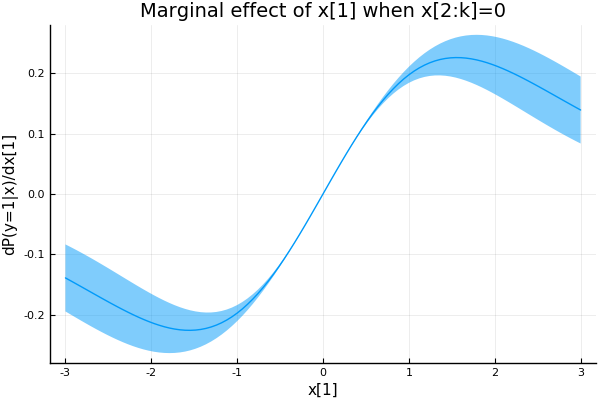

In [6]:
using LinearAlgebra
function logit_mfx(β,x)
  ForwardDiff.jacobian(β-> map(xb -> cdf(Logistic(),xb), x*β), β)  
end

function delta_method(g, θ, Ω)
  dG = ForwardDiff.jacobian(θ->g(θ),θ)
  dG*Ω*dG'  
end

nfx = 100
xmfx = zeros(nfx,3)
xmfx[:,1] .= -3.0:(6.0/(nfx-1)):3.0

mfx = logit_mfx(βhat,xmfx)
vmfx = delta_method(β->logit_mfx(β,xmfx)[:,1], βhat, avar.variance/n)
sdfx = sqrt.(diag(vmfx))

using Plots
Plots.pyplot()
plot(xmfx[:,1],mfx[:,1],ribbon=quantile(Normal(),0.95)*sdfx,fillalpha=0.5,
     xlabel="x[1]", ylabel="dP(y=1|x)/dx[1]", legend=false,
         title="Marginal effect of x[1] when x[2:k]=0")

The same approach can be used to compute standard errors and
confidence regions for the results of more complicated counterfactual
simulations, as long as the associated simulations are smooth
functions of the parameters. However, sometimes it might be more
natural to write simulations with outcomes that are not smooth in the
parameters. For example, the following code uses simulation to
calculate the change in the probability of $y$ from adding 0.1 to
$x$.

In [7]:
function counterfactual_sim(β, x, S)
  function onesim()
    e = rand(Logistic(), size(x)[1])
    baseline= (x*β .+ e .> 0)
    counterfactual= ((x.+0.1)*β .+ e .> 0)
    mean(counterfactual.-baseline)
  end
  mean([onesim() for s in 1:S])
end
ForwardDiff.gradient(β->counterfactual_sim(β,x,10),βhat)

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Here, the gradient is 0 because the simulation function is a
step-function. In this situation, an alternative to the delta method
is the simulation based approach of @krinsky1986. The procedure is
quite simple. Suppose 
$\sqrt{n}(\hat{\theta} - \theta_0) \indist N(0,\Omega)$,
and you want to an estimate of the distribution of $g(\theta)$. 
Repeatedly draw $\theta_s \sim N(\hat{\theta}, \Omega/n)$ and compute
$g(\theta_s)$. Use the distribution of $g(\theta_s)$ for
inference. For example, a 90% confidence interval for $g(\theta)$
would be the 5%-tile of $g(\theta_s)$ to the 95%-tile of
$g(\theta_s)$.

In [8]:
Ω = avar.variance/n
Ω = (Ω+Ω')/2         # otherwise, it's not exactly symmetric due to
                     # floating point roundoff
function kr_confint(g, θ, Ω, simulations; coverage=0.9)
  θs = [g(rand(MultivariateNormal(θ,Ω))) for s in 1:simulations]
  quantile(θs, [(1.0-coverage)/2, coverage + (1.0-coverage)/2])
end

@show kr_confint(β->counterfactual_sim(β,x,10), βhat, Ω, 1000)

# a delta method based confidence interval for the same thing
function counterfactual_calc(β, x)
  baseline      = cdf.(Logistic(), x*β)
  counterfactual= cdf.(Logistic(), (x.+0.1)*β)
  return([mean(counterfactual.-baseline)])
end
v = delta_method(β->counterfactual_calc(β,x), βhat, Ω)
ghat = counterfactual_calc(βhat,x)
@show [ghat + sqrt(v)*quantile(Normal(),0.05), ghat +
       sqrt(v)*quantile(Normal(),0.95)]

kr_confint((β->begin
            #= In[8]:9 =#
            counterfactual_sim(β, x, 10)
        end), βhat, Ω, 1000) = [0.044695, 0.053]
[ghat + sqrt(v) * quantile(Normal(), 0.05), ghat + sqrt(v) * quantile(Normal(), 0.95)] = Array{Float64,2}[[0.0467324], [0.0510979]]


2-element Array{Array{Float64,2},1}:
 [0.0467324]
 [0.0510979]

# Alternative approaches to inference

## Identification robust inference

As discussed in section 9 of @newey1994, there are three classic types
of statistics for testing restrictions on parameters. Suppose you want
to test $H_0: a(\theta) = 0$. Let $\hat{\theta}$ denote the
unrestricted estimate, and let $\hat{\theta}^r$ denote the
estimate of $\theta$ subject to the restriction. Wald test-statistics
are based on $\hat{\theta}-\hat{\theta}^r$. Lagrange multiplier tests
look at the distribution of the estimated Lagrange
multiplier. Likelihood ratio (aka distance metric in @newey1994) tests
look at $Q_n(\hat{\theta}) - Q_n(\hat{\theta}^r)$. If we consider
testing $H_0: \theta = \vartheta$ for some fixed $\vartheta$, then the
usual approach based on the asymptotic normality of $\hat{\theta}$
discussed above is exactly the same as the Wald test of this
restriction. As discussed by @newey1994, under standard assumptions,
all three testing approaches are asymptotically equivalent. However,
the tests can and will differ in finite samples. More importantly, in
the face of identification problems, Wald tests tend to break down,
while Lagrange multiplier and likelihood ratio style tests can
continue to work. 

By identification robust, we mean an inference procedure that has
correct size regardless of whether identification is strong, weak,
or partial. In the asymptotic normality of extremum estimators theorem
above, non-strong identification will create problems for assumption
3, in particular the assumption that the Hessian is non-singular. For
this section, we will focus on GMM estimators. Identification problems
most often arrive and have been studied in the context of GMM. Also,
it is not difficult to transform other extremum estimators into GMM. 

For a GMM objective function of the form:
$$ [1/n \sum_i g_i(\theta)] W_n [1/n \sum g_i(\theta]$$, 
if we assume:

1. $1/\sqrt{n} \sum_i g_i(\theta_0) \indist N(0,\Sigma)$

2. $1/n \sum_i \nabla g_i(\theta) \inprob E[\nabla g(\theta)]$, 
   $W_n \inprob W$

3. $(D'WD)$ is nonsingular.

then the above theorem for asymptotic normality of extremum
estimators implies that 
$$
\sqrt{n}(\hat{\theta} - \theta_0) \indist N(0,\Omega)
$$
where 
$$
 \Omega= (D'WD)^{-1} (D' W \Sigma W D) (D'WD)^{-1}.
$$
If we additionally assume $W_n \inprob \Sigma^{-1}$, e.g. observations
are independent and $W_n =
\widehat{Var}(g_i(\theta))^{-1}$, then the asymptotic variance
simplifies to $(D' \Sigma D)^{-1}$. 

### Anderson-Rubin test

As already stated, the assumption that $(D'WD)$ is nonsingular is
problematic if we want to allow for identification problems. However,
if we assume only that 

1. $1/\sqrt{n} \sum_i g_i(\theta_0) \indist N(0,\Sigma)$

2. $W_n \inprob \Sigma^{-1}$

then 
$$
n [1/n \sum g_i(\theta_0)]' W_n^{-1} [1/n \sum g_i(\theta_0)]
  \indist \chi^2_m
$$
where $m$ is the number of moments (dimension of $g_i(\theta)$). This
is called the Anderson-Rubin test. Note that this result holds without
any explicit nonsingular assumption about a Hessian. Hence, there is
hope that this result would be true even with identification
problems. Indeed, it is. @stock2000 first proposed using this test
statistic for weakly identified GMM estimators. @stock2002 gives an
overview of this test and related tests with a focus on linear IV. @caner2009

Typical usage of the AR test is to invert the test to construct a
confidence region for $\theta$. For each $\theta \in \Theta$, 
let 
$$
AR(\theta) = n [1/n \sum g_i(\theta)]' \widehat{Var}(g_i(\theta))^{-1}
[1/n \sum g_i(\theta)] 
$$
and let $c_{\alpha}= \alpha$ quantile of $\chi^2_m$. Then a $\alpha$
confidence region for $\theta_0$ is
$$
\{ \theta \in \Theta: AR(\theta) \leq c_\alpha \}
$$

### Example: IV logit demand

A common way to model demand for differentiated products is to
aggregate an individual discrete choice. We will look at the simplest
such model here. This is a model for when we have data on product
market shares, $y_j$, and product attributes, $x_j$, for many
different markets. In concrete applications, markets may be defined
geographically, temporally, by consumer segment, or some combination
thereof. 

Consider a single good, which consumers chooose to
purchase or not. Consumer $i$'s utility from consuming the good is
$$
u_{ij} = x_j \beta + \xi_j + \epsilon_{ij}
$$
where $x_j$ are the observed attributes of the good in market $j$,
$\xi_j$ is a market level demand shock, and $\epsilon_{ij}$ is an
individual taste shock. Person $i$ purchases the good if 
$u_{ij} \geq 0$. Aggregating individual purchases implies that the
market share in market $j$ is 
$$ y_j = F_{-\epsilon}(x_j \beta + \xi_j) $$
where $F_{-\epsilon}$ is the CDF of $-\epsilon$.

We assume that $\epsilon_{ij}$ is independent of $x_j$ and
$\xi_j$. Typically, $x_j$ includes some easily adjusted product
attributes, such as price, so we want to allow $x_j$ to be correlated
with $\xi_j$. Assume that we have some instruments $z_j$ such that
$\Er[\xi_j z_j]=0.$  We can write this moment condition in terms of
observables and $\beta$ as
$$ \Er[ (F^{-1}_{-\epsilon}(y_j) - x_j\beta) z_j ] = 0 $$
This is the moment condition we will use to estimate $\beta$.

First, we will simulate the model, then estimate it. This code looks
at three variants of GMM. First, it computes an estimate with 
$W_n = I$. Second, it computes an effeciently weighted estimated with 
$W_n = \widehat{Var}( \nabla g_i(\hat{\theta}_{(1)}) )$, where
$\hat{\theta}_{(1)}$ is the first estimate. Third, it computes the
continuous updating estimator, which uses $AR(\theta)$ as the
objective function ($W$ is "continuously updated" to be 
$\widehat{Var}( \nabla g_i(\theta))$).

In [9]:
using Optim, ForwardDiff, LinearAlgebra, Distributions
function simulate_ivshare(n,β,γ,ρ)
  z = randn(n, size(γ)[1])
  endo = randn(n, length(β))
  x = z*γ .+ endo
  ξ = rand(Normal(0,sqrt((1.0-ρ^2))),n).+endo[:,1]*ρ 
  y = cdf.(Logistic(), x*β .+ ξ)
  return((y=y,x=x,z=z))  
end
n = 100
k = 2
iv = 3
β0 = ones(k)
π0 = vcat(diagm(0=>ones(k)),ones(iv-k,k)) 
ρ = 0.5  
(y,x,z) = simulate_ivshare(n,β0,π0,ρ)

function gi_ivshare(β,y,x,z)
  ξ = quantile.(Logistic(),y) .- x*β
  ξ.*z
end

function gmmObj(θ,gi,W)
  g = gi(θ)
  m = mean(g,dims=1)
  (size(g)[1]*( m*W*m')[1]) # return scalar, not 1x1 array
end

function gmmVar(θ,gi,W)
  g = gi(θ)
  n = size(g)[1]
  D = ForwardDiff.jacobian(θ->mean(gi(θ),dims=1),θ)
  Σ = cov(gi(θ))
  1/n*inv(D'*W*D)*(D'*Σ*D)*inv(D'*W*D)
end

function ar(θ,gi)
  gmmObj(θ,gi,inv(cov(gi(θ))))
end

ar (generic function with 1 method)

In [10]:
opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                zeros(k), BFGS(), autodiff =:forward)
@show β1 = opt1.minimizer
display(gmmVar(β1, β->gi_ivshare(β,y,x,z),I))
opteff = optimize(θ->gmmObj(θ,β->gi_ivshare(β,y,x,z),inv(cov(gi_ivshare(β1,y,x,z)))),
                  zeros(k), BFGS(), autodiff =:forward)
@show βeff = opteff.minimizer
display(gmmVar(βeff,β->gi_ivshare(β,y,x,z),inv(cov(gi_ivshare(β1,y,x,z)))))

ar_ivshare = θ->ar(θ,β->gi_ivshare(β,y,x,z))
optcue = optimize(ar_ivshare,
                  β0, BFGS(), autodiff =:forward)
@show βcue = optcue.minimizer
Vcue = gmmVar(βcue,β->gi_ivshare(β,y,x,z),inv(cov(gi_ivshare(βcue,y,x,z))))
display(Vcue)

2×2 Array{Float64,2}:
  0.00951562  -0.00439299
 -0.00439299   0.00994608

β1 = opt1.minimizer = [0.922068, 0.86884]
βeff = opteff.minimizer = 

2×2 Array{Float64,2}:
  0.00528323  -0.00305377
 -0.00305377   0.0101466 

[0.889263, 0.946173]


2×2 Array{Float64,2}:
  0.00565194  -0.00251141
 -0.00251141   0.0105442 

βcue = optcue.minimizer = [0.857151, 0.975535]


Now we compare confidence regions based on the Wald test, and from
inverting the AR statistic.

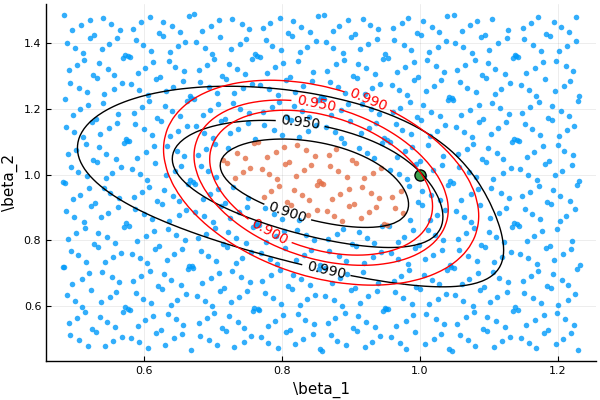

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [11]:
using Sobol, Plots
function plot_cr(β,V, AR)
  lb = β - sqrt.(diag(V))*5
  ub = β + sqrt.(diag(V))*5
  ntest = 1000
  rng = SobolSeq(2)
  βtest = [next!(rng).*(ub-lb) .+ lb for i in 1:ntest]
  arstat = AR.(βtest)
  βtest = vcat(βtest'...)
  crit = quantile(Chisq(size(z)[2]), 0.9)
  scatter(βtest[:,1],βtest[:,2], group=(arstat.<crit), legend=false,
          markersize=4, markerstrokewidth=0.0, seriesalpha=0.8,
          xlabel="\\beta_1", ylabel="\\beta_2")
  scatter!([β0[1]], [β0[2]], markersize=8)
  b1 = lb[1]:(ub[1]-lb[1])/100:ub[1]
  b2 = lb[2]:(ub[2]-lb[2])/100:ub[2]
  arf = (a,b) -> cdf(Chisq(size(z)[2]),AR([a,b]))
  contour!(b1,b2,arf, levels = [0.75,0.9, 0.95, 0.99],
           contour_labels=true, legend=false, c=cgrad([:black,:black],[0.0,1.0]))
  waldf = (a,b) -> cdf(Chisq(length(βcue)),([a,b]-βcue)'*inv(Vcue)*([a,b]-βcue))
  contour!(b1,b2,waldf, levels = [0.9, 0.95, 0.99],
           contour_labels=true,
           label="Wald CI", c=cgrad([:red,:red], [0.0,1.0]),
           legend=false)
end
plot_cr(βcue,Vcue, ar_ivshare)

The two confidence regions above are not too different because the
simulated data was strongly identified. Let's see what happens when we
change the simulation to have weaker identification.

2×2 Array{Float64,2}:
  0.497725  -0.507496
 -0.507496   0.51934 

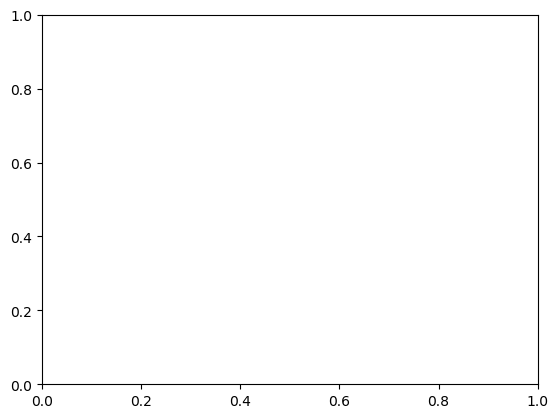

βcue = optcue.minimizer = [1.06692, 0.899223]


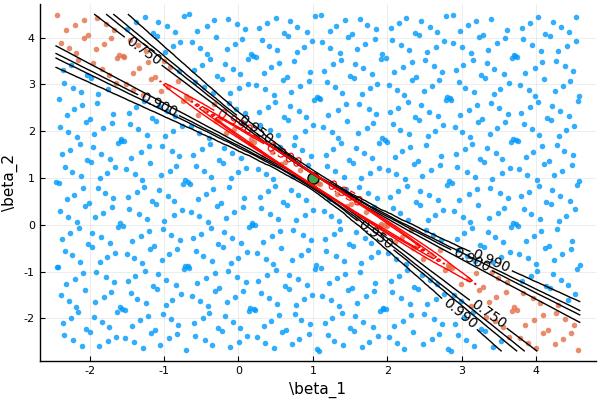

/usr/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [12]:
# make π0 nearly rank-deficient
π0 = ones(iv,k) .+ vcat(diagm(0=>fill(0.1,k)),zeros(iv-k,k))  
ρ = 0.5  
(y,x,z) = simulate_ivshare(n,β0,π0,ρ)
ar_ivshare = θ->ar(θ,β->gi_ivshare(β,y,x,z))
optcue = optimize(ar_ivshare,
                  β0, BFGS(), autodiff =:forward)
@show βcue = optcue.minimizer
Vcue = gmmVar(βcue,β->gi_ivshare(β,y,x,z),inv(cov(gi_ivshare(βcue,y,x,z))))
display(Vcue)
plot_cr(βcue,Vcue, ar_ivshare)

Now the confidence regions are dramatically different. Does either one
have correct coverage? Let's simulate to find the size of the AR and
Wald tests of $H_0 : \beta = \beta_0$

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/pack

Results of Optimization Algorithm
 * Algorithm: Newton's Method (Trust Region)
 * Starting Point: [1.0,1.0]
 * Minimizer: [-5364.962382576264,5987.45005756862]
 * Minimum: 2.093857e-01
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 2.03e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 3.56e-07 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.03e-08 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001
 * Gradient Calls: 1001
 * Hessian Calls: 1001

┌ Warning: Linesearch failed, using alpha = 7.105427357601002e32 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47


Results of Optimization Algorithm
 * Algorithm: Newton's Method (Trust Region)
 * Starting Point: [1.0,1.0]
 * Minimizer: [-4784.027687987458,5037.751144416199]
 * Minimum: 5.412579e-01
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.71e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.03e-07 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.71e-08 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001
 * Gradient Calls: 1001
 * Hessian Calls: 1001

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/pack

Results of Optimization Algorithm
 * Algorithm: Newton's Method (Trust Region)
 * Starting Point: [1.0,1.0]
 * Minimizer: [-4484.838450567966,4427.276792896902]
 * Minimum: 2.795004e-01
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.52e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 1.63e-07 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.52e-08 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001
 * Gradient Calls: 1001
 * Hessian Calls: 1001

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /home/paul/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47


 14.160306 seconds (34.33 M allocations: 2.816 GiB, 14.94% gc time)
 

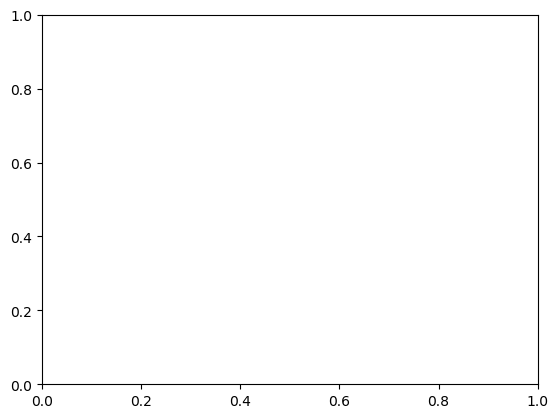

 0.595703 seconds (1.18 M allocations: 614.564 MiB, 31.99% gc time)


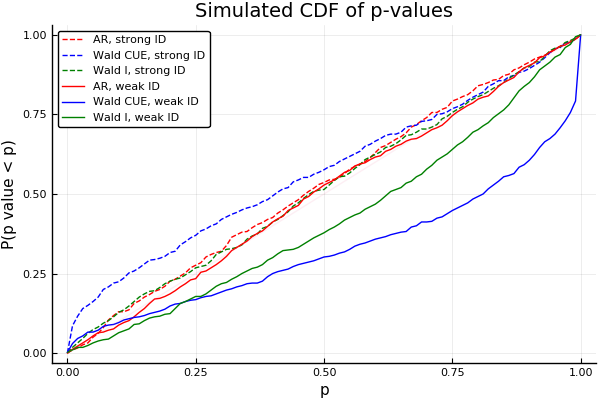

In [13]:
S = 500
n = 100
function sim_p(π0)
  (y,x,z) = simulate_ivshare(n,β0,π0,ρ)
  opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                  β0, BFGS(), autodiff =:forward)
  if (!opt1.g_converged)
    opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                    β0, NewtonTrustRegion(), autodiff =:forward)
  end
  β1 = opt1.minimizer

  V1 = gmmVar(β1,β->gi_ivshare(β,y,x,z),I)
  
  optcue = optimize(θ->ar(θ,β->gi_ivshare(β,y,x,z)),
                    β0, BFGS(), autodiff =:forward)
  if (!optcue.g_converged)
    optcue = optimize(θ->ar(θ,β->gi_ivshare(β,y,x,z)),
                      β0, NewtonTrustRegion(), autodiff =:forward)
  end
  if (!optcue.g_converged)
    display(optcue)
    βcue = deepcopy(β1)
  else 
    βcue = optcue.minimizer
  end
  Vcue =
    gmmVar(βcue,β->gi_ivshare(β,y,x,z),inv(cov(gi_ivshare(βcue,y,x,z))))
  arp = θ->(1.0-cdf(Chisq(size(z)[2]),ar(θ,β->gi_ivshare(β,y,x,z))))
  waldp = θ->(1.0-cdf(Chisq(length(βcue)),(θ-βcue)'*inv(Vcue)*(θ-βcue)))
  waldp1 = θ->(1.0-cdf(Chisq(length(β1)),(θ-β1)'*inv(V1)*(θ-β1)))
  [arp(β0) waldp(β0) waldp1(β0)]
end
πweak = ones(iv,k) .+ vcat(diagm(0=>fill(0.1,k)),zeros(iv-k,k))  
πstrong = vcat(diagm(0=>ones(k)),ones(iv-k,k)) 
@time pweak=vcat([sim_p(πweak) for s in 1:S]...)
@time pstrong=vcat([sim_p(πstrong) for s in 1:S]...)

pgrid = 0:0.01:1
plot(pgrid, p->mean( pstrong[:,1] .<= p), legend=:topleft,
     label="AR, strong ID", style=:dash, color=:red,
     xlabel="p", ylabel="P(p value < p)",
     title="Simulated CDF of p-values") 
plot!(pgrid, p->mean( pstrong[:,2] .<= p),
      label="Wald CUE, strong ID", style=:dash, color=:blue)
plot!(pgrid, p->mean( pstrong[:,3] .<= p),
      label="Wald I, strong ID", style=:dash, color=:green)

plot!(pgrid, p->mean( pweak[:,1] .<= p),
      label="AR, weak ID", style=:solid, color=:red)
plot!(pgrid, p->mean( pweak[:,2] .<= p),
      label="Wald CUE, weak ID", style=:solid, color=:blue)
plot!(pgrid, p->mean( pweak[:,3] .<= p),
      label="Wald I, weak ID", style=:solid, color=:green)

plot!(pgrid,pgrid,alpha=0.1, label="")

We see that the Wald test has fairly large size distortions, even when
identification is strong. The AR test has approximately correct size
for both the weakly and strongly identified DGP. 

### Other identification robust tests

There are also identification robust versions of likelihood ratio and
lagrange multiplier test. @moreira2003 proposed a conditional
likelihood ratio (CLR) test for weakly identified linear IV
models. @kleibergen2005 developed a Lagrange multiplier (often called
the KLM) test and extended Moreira's CLR test to weakly identified GMM
models.  More recently, @andrews2015 and @andrews2017 showed the
validity of these tests under more general conditions. These tests are
somewhat more complicated than the AR test, but they have the
advantage that they are often more powerful. The AR test statistic has
a $\chi^2_{m}$ distribution, where $m$ is the number of moments. The
CLR and KLM statistics under strong identification have $\chi^2_k$
distributions (as does the Wald statistic), where $k$ is the number of
parameters. Consequently, when the model is overidentified, the CLR
and LM tests are more powerful than the AR test. 


Here is an implementation of the KLM and CLR statistics. The names of
variables roughly follows the notation of @andrews2017.

In [14]:
using ForwardDiff, Plots, Optim

function statparts(θ,gi)
  # compute common components of klm, rk, & clr stats
  # follows notation of Andrews & Guggenberger 2017, section 3.1
  function P(A::AbstractMatrix) # projection matrix
    A*pinv(A'*A)*A'
  end
  giθ = gi(θ)
  p = length(θ)    
  (n, k) = size(giθ)
  Ω = cov(giθ)  
  gn=mean(gi(θ), dims=1)'
  #G = ForwardDiff.jacobian(θ->mean(gi(θ),dims=1),θ)
  Gi= ForwardDiff.jacobian(gi,θ)
  Gi = reshape(Gi, n , k, p)
  G = mean(Gi, dims=1)
  Γ = zeros(eltype(G),p,k,k)
  D = zeros(eltype(G),k, p)
  for j in 1:p
    for i in 1:n
      Γ[j,:,:] += (Gi[i,:,j] .- G[1,:,j]) * giθ[i,:]'
    end
    Γ[j,:,:] ./= n
    D[:,j] = G[1,:,j] - Γ[j,:,:]*inv(Ω)*gn
  end
  return(n,k,p,gn, Ω, D, P)
end

function klm(θ,gi)
  (n,k,p,gn, Ω, D, P) = statparts(θ,gi)
  lm = n*(gn'*Ω^(-1/2)*P(Ω^(-1/2)*D)*Ω^(-1/2)*gn)[1]
end

function clr(θ,gi)
  (n,k,p,gn, Ω, D, P) = statparts(θ,gi)
  
  rk = eigmin(n*D'*inv(Ω)*D)
  AR  = (n*gn'*inv(Ω)*gn)[1]
  lm = (n*(gn'*Ω^(-1/2)*P(Ω^(-1/2)*D)*Ω^(-1/2)*gn))[1]  
  lr = 1/2*(AR - rk + sqrt( (AR-rk)^2 + 4*lm*rk))
  
  # simulate to find p-value
  S = 5000
  function randc(k,p,r,S)
    χp = rand(Chisq(p),S)
    χkp = rand(Chisq(k-p),S)
    0.5.*(χp .+ χkp .- r .+
          sqrt.((χp .+ χkp .- r).^2 .+ 4 .* χp.*r))
  end
  csim = randc(k,p,rk,S)
  pval = mean(csim.<=lr)
end

clr (generic function with 1 method)

In [15]:
function plot_cr(β,V, tests::AbstractArray{Function}, labels; ngrid=30)
  lb = β - sqrt.(diag(V))*5
  ub = β + sqrt.(diag(V))*5
  fig=scatter([β0[1]], [β0[2]], markersize=8, legend=false,
              xlabel="β1", ylabel="β2")
  ntest = 1000
  βtest = [rand(2).*(ub-lb) .+ lb for i in 1:ntest]
  pval = tests[1].(βtest)
  βtest = vcat(βtest'...)
  crit = 0.9
  fig=scatter!(βtest[:,1],βtest[:,2], group=(pval.<crit), legend=false,
               markersize=4, markerstrokewidth=0.0, seriesalpha=0.5,
               palette=:heat)
  b1 = lb[1]:(ub[1]-lb[1])/ngrid:ub[1]
  b2 = lb[2]:(ub[2]-lb[2])/ngrid:ub[2]
  colors = [:black, :red, :blue, :green]
  for t in 1:length(tests)
    fig=contour!(b1,b2,(a,b)->tests[t]([a,b]),
             levels = [0.9, 0.95],
             contour_labels=true, legend=false,
             label = labels[t],
             c=cgrad([colors[t],colors[t]],[0.0,1.0]))
  end
  fig
end

plot_cr (generic function with 2 methods)

Here's what the confidence regions look like when identification is
fairly weak. The green lines are the Wald confidence region, blue is
AR, red is KLM, and black is CLR.

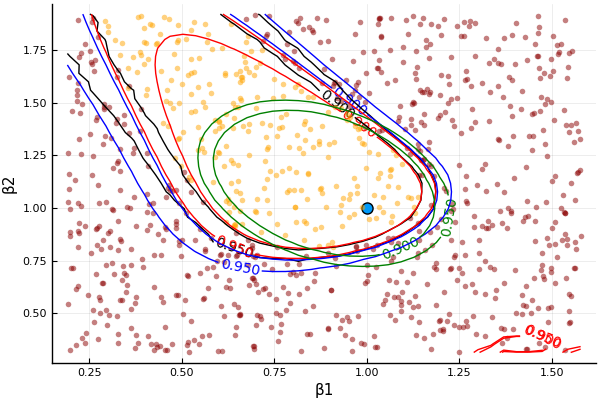

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [16]:
n = 50
k = 2
iv =3 
π0 = vcat(diagm(0=>ones(k)),0.2*ones(iv-k,k)) 
ρ = 0.5  
(y,x,z) = simulate_ivshare(n,β0,π0,ρ)
opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                β0, BFGS(), autodiff =:forward)
β1 = opt1.minimizer
V1 = gmmVar(β1,β->gi_ivshare(β,y,x,z),I)
  

pklm = θ->cdf(Chisq(length(βcue)),klm(θ, β->gi_ivshare(β,y,x,z)))
par  = θ->cdf(Chisq(size(z)[2]), ar(θ, β->gi_ivshare(β,y,x,z)))
pclr  = θ->clr(θ, β->gi_ivshare(β,y,x,z))
pwald = θ -> cdf(Chisq(length(β1)),(θ-β1)'*inv(V1)*(θ-β1))
plot_cr(β1,V1, [pclr, pklm, par, pwald],
        ["CLR","KLM","AR","Wald"], ngrid=40)

Here's what the confidence regions look like when identification is
stronger.

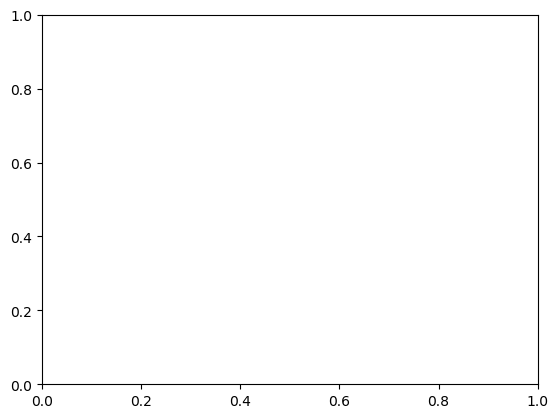

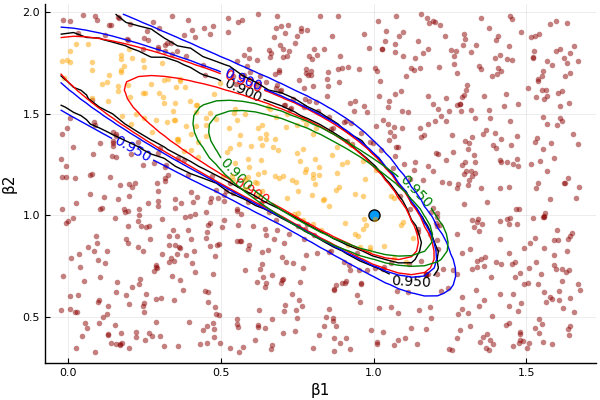

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [17]:
n = 50
k = 2
iv =3 
π0 = vcat(diagm(0=>ones(k)),ones(iv-k,k)) 
ρ = 0.5  
(y,x,z) = simulate_ivshare(n,β0,π0,ρ)
opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                β0, BFGS(), autodiff =:forward)
β1 = opt1.minimizer
V1 = gmmVar(β1,β->gi_ivshare(β,y,x,z),I)
  

pklm = θ->cdf(Chisq(length(βcue)),klm(θ, β->gi_ivshare(β,y,x,z)))
par  = θ->cdf(Chisq(size(z)[2]), ar(θ, β->gi_ivshare(β,y,x,z)))
pclr  = θ->clr(θ, β->gi_ivshare(β,y,x,z))
pwald = θ -> cdf(Chisq(length(β1)),(θ-β1)'*inv(V1)*(θ-β1))
plot_cr(β1,V1, [pclr, pklm, par, pwald],
        ["CLR","KLM","AR","Wald"], ngrid=40)

Check the size

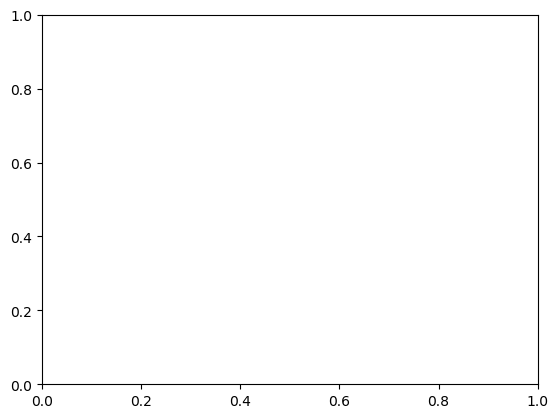

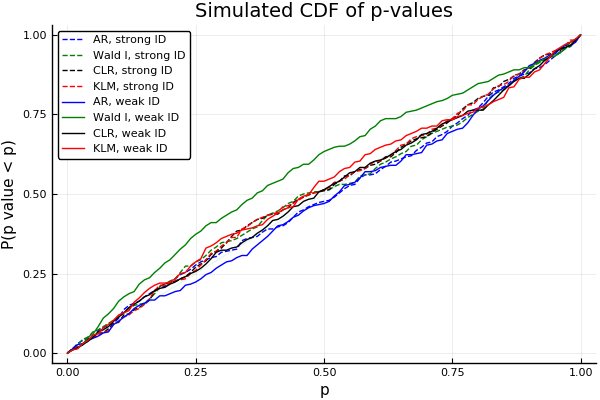

In [18]:
S = 300
n = 100
function sim_p(π0)
  (y,x,z) = simulate_ivshare(n,β0,π0,ρ)
  opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                  β0, BFGS(), autodiff =:forward)
  if (!opt1.g_converged)
    opt1 = optimize(θ->gmmObj(θ, β->gi_ivshare(β,y,x,z) ,I),
                    β0, NewtonTrustRegion(), autodiff =:forward)
  end
  β1 = opt1.minimizer
  V1 = gmmVar(β1,β->gi_ivshare(β,y,x,z),I)
  
  pklm = θ->cdf(Chisq(length(β1)),klm(θ, β->gi_ivshare(β,y,x,z)))
  par  = θ->cdf(Chisq(size(z)[2]), ar(θ, β->gi_ivshare(β,y,x,z)))
  pclr  = θ->clr(θ, β->gi_ivshare(β,y,x,z))
  pwald = θ -> cdf(Chisq(length(β1)),(θ-β1)'*inv(V1)*(θ-β1))  
  [par(β0) pwald(β0) pclr(β0) pklm(β0)]
end
πweak = ones(iv,k) .+ vcat(diagm(0=>fill(0.1,k)),zeros(iv-k,k))  
πstrong = vcat(diagm(0=>ones(k)),ones(iv-k,k)) 
pweak=vcat([sim_p(πweak ) for s in 1:S]...)
pstrong=vcat([sim_p(πstrong) for s in 1:S]...)

pgrid = 0:0.01:1
plot(pgrid, p->mean( pstrong[:,1] .<= p), legend=:topleft,
     label="AR, strong ID", style=:dash, color=:blue,
     xlabel="p", ylabel="P(p value < p)",
     title="Simulated CDF of p-values") 
plot!(pgrid, p->mean( pstrong[:,2] .<= p),
      label="Wald I, strong ID", style=:dash, color=:green)
plot!(pgrid, p->mean( pstrong[:,3] .<= p),
      label="CLR, strong ID", style=:dash, color=:black)
plot!(pgrid, p->mean( pstrong[:,4] .<= p),
      label="KLM, strong ID", style=:dash, color=:red)

plot!(pgrid, p->mean( pweak[:,1] .<= p),
      label="AR, weak ID", style=:solid, color=:blue)
plot!(pgrid, p->mean( pweak[:,2] .<= p),
      label="Wald I, weak ID", style=:solid, color=:green)
plot!(pgrid, p->mean( pweak[:,3] .<= p),
      label="CLR, weak ID", style=:solid, color=:black)
plot!(pgrid, p->mean( pweak[:,4] .<= p),
      label="KLM, weak ID", style=:solid, color=:red)
plot!(pgrid,pgrid,alpha=0.1, label="")

<!--- Add details and example code for KLM & CLR tests--->

## Bootstrap

The bootstrap and related simulation methods can also be used for
inference. We will look at these in more detail in the next set of notes.

## Bayesian methods

Bayesian methods give an alternative approach to both estimation and
inference. In some situations, Bayesian methods can be more convenient
and/or more numerically robust. In well behaved settings, when viewed
from a frequentist perspective, Bayesian methods asymptotically give
the same results as MLE (or efficiently weighted GMM in the case of
quasi-Bayesian models).